# Brasil - LSTM 

# 1º Entendimento do problema
O objetivo é realizar a previsão dos novos casos de COVID 19 no Brasil. Considerando 10 dias sequenciais de previsão.

In [ ]:
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.metrics import *
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint

# 2º Análise Exploratória dos Dados

In [ ]:
# import directly from GitHub
df = pd.read_csv("https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv")
df.head()

,epi_week,date,country,state,city,newDeaths,deaths,newCases,totalCases,deathsMS,totalCasesMS,deaths_per_100k_inhabitants,totalCases_per_100k_inhabitants,deaths_by_totalCases,recovered,suspects,tests,tests_per_100k_inhabitants,vaccinated,vaccinated_per_100_inhabitants,vaccinated_second,vaccinated_second_per_100_inhabitants,vaccinated_single,vaccinated_single_per_100_inhabitants,vaccinated_third,vaccinated_third_per_100_inhabitants
0,9,2020-02-25,Brazil,SP,TOTAL,0,0,1,1,0,0,0.0,0.00218,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,2020-02-25,Brazil,TOTAL,TOTAL,0,0,1,1,0,0,0.0,0.00047,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9,2020-02-26,Brazil,SP,TOTAL,0,0,0,1,0,1,0.0,0.00218,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,2020-02-26,Brazil,TOTAL,TOTAL,0,0,0,1,0,1,0.0,0.00047,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,2020-02-27,Brazil,SP,TOTAL,0,0,0,1,0,1,0.0,0.00218,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### **Ajuste das colunas e definição do período**
#### O dataset possui atualização diária, portanto faz necessário fixar um período
##### **Período fixado: 1/1/2021 a 31/1/2022**

In [ ]:
# Ajusta tipo da coluna 'date' para data
df['date'] = pd.to_datetime(df['date'])

In [ ]:
# Define novo dataset com os totais diários para o BRASIL, de 1 de janeiro de 2021 até o dia 31 de janeiro de 2022

df_total = df[(df['state'] == 'TOTAL')] # & (df['date'] >= '2021-01-01') & (df['date'] <= '2022-01-31')]
df_total.reset_index(drop=True, inplace=True)

In [ ]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   epi_week                               731 non-null    int64         
 1   date                                   731 non-null    datetime64[ns]
 2   country                                731 non-null    object        
 3   state                                  731 non-null    object        
 4   city                                   731 non-null    object        
 5   newDeaths                              731 non-null    int64         
 6   deaths                                 731 non-null    int64         
 7   newCases                               731 non-null    int64         
 8   totalCases                             731 non-null    int64         
 9   deathsMS                               731 non-null    int64     

In [ ]:
df_total.head()

,epi_week,date,country,state,city,newDeaths,deaths,newCases,totalCases,deathsMS,totalCasesMS,deaths_per_100k_inhabitants,totalCases_per_100k_inhabitants,deaths_by_totalCases,recovered,suspects,tests,tests_per_100k_inhabitants,vaccinated,vaccinated_per_100_inhabitants,vaccinated_second,vaccinated_second_per_100_inhabitants,vaccinated_single,vaccinated_single_per_100_inhabitants,vaccinated_third,vaccinated_third_per_100_inhabitants
0,9,2020-02-25,Brazil,TOTAL,TOTAL,0,0,1,1,0,0,0.0,0.00047,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,2020-02-26,Brazil,TOTAL,TOTAL,0,0,0,1,0,1,0.0,0.00047,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9,2020-02-27,Brazil,TOTAL,TOTAL,0,0,0,1,0,1,0.0,0.00047,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,2020-02-28,Brazil,TOTAL,TOTAL,0,0,1,2,0,1,0.0,0.00094,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,2020-02-29,Brazil,TOTAL,TOTAL,0,0,0,2,0,2,0.0,0.00094,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_total.tail()

,epi_week,date,country,state,city,newDeaths,deaths,newCases,totalCases,deathsMS,totalCasesMS,deaths_per_100k_inhabitants,totalCases_per_100k_inhabitants,deaths_by_totalCases,recovered,suspects,tests,tests_per_100k_inhabitants,vaccinated,vaccinated_per_100_inhabitants,vaccinated_second,vaccinated_second_per_100_inhabitants,vaccinated_single,vaccinated_single_per_100_inhabitants,vaccinated_third,vaccinated_third_per_100_inhabitants
726,208,2022-02-20,Brazil,TOTAL,TOTAL,399,644612,38651,28220503,644286,28208212,302.18411,13229.33403,0.02284,24781643.0,8866327.0,69640999.0,32646.62,171184070.0,80.24844,148465653.0,69.59840,5038241.0,2.36185,60718520.0,28.46390
727,208,2022-02-21,Brazil,TOTAL,TOTAL,343,644955,43880,28264383,644604,28245551,302.34490,13249.90429,0.02282,24781643.0,8866327.0,69640999.0,32646.62,171365006.0,80.33326,148612368.0,69.66717,5041937.0,2.36358,61279822.0,28.72703
728,208,2022-02-22,Brazil,TOTAL,TOTAL,804,645759,102606,28366989,645420,28351327,302.72180,13298.00439,0.02276,25024038.0,8866327.0,69640999.0,32646.62,171582608.0,80.43526,148733178.0,69.72381,5043146.0,2.36415,61868082.0,29.00280
729,208,2022-02-23,Brazil,TOTAL,TOTAL,985,646744,130861,28497850,646419,28484890,303.18355,13359.35000,0.02269,25024038.0,8866327.0,69640999.0,32646.62,171875375.0,80.57251,149019409.0,69.85799,5044945.0,2.36499,62367146.0,29.23675
730,208,2022-02-24,Brazil,TOTAL,TOTAL,959,647703,91385,28589235,647390,28578647,303.63312,13402.18987,0.02266,25024038.0,8866327.0,69640999.0,32646.62,172145965.0,80.69936,149264730.0,69.97299,5041384.0,2.36332,63262839.0,29.65664


In [ ]:
# Verificando as colunas
df_total.columns

Index(['epi_week', 'date', 'country', 'state', 'city', 'newDeaths', 'deaths',
       'newCases', 'totalCases', 'deathsMS', 'totalCasesMS',
       'deaths_per_100k_inhabitants', 'totalCases_per_100k_inhabitants',
       'deaths_by_totalCases', 'recovered', 'suspects', 'tests',
       'tests_per_100k_inhabitants', 'vaccinated',
       'vaccinated_per_100_inhabitants', 'vaccinated_second',
       'vaccinated_second_per_100_inhabitants', 'vaccinated_single',
       'vaccinated_single_per_100_inhabitants', 'vaccinated_third',
       'vaccinated_third_per_100_inhabitants'],
      dtype='object')

### Gráficos da variável Target

# 2º Pré-processamento dos dados
**Features adicionadas:** newCasesMS, newDeathMS, day, month, year, day_of_week

In [ ]:
# Definindo o número de casos e o número de mortes diários segundo o MS
df_total['newCasesMS'] = df_total['totalCasesMS'].diff()
df_total['newDeathsMS'] = df_total['deathsMS'].diff()

# Definindo o número de recuperados, suspeitos, testes, vacinados e vacinados pela segunda vez diários
df_total['newRecovered'] = df_total['recovered'].diff()
df_total['newSuspects'] = df_total['suspects'].diff()
df_total['newTests'] = df_total['tests'].diff()
df_total['newVaccinated'] = df_total['vaccinated'].diff()
df_total['newVaccinated_second'] = df_total['vaccinated_second'].diff()

# Ajustando o valor do primeiro elemento de cada nova coluna. A operação 'diff()' faz com que esses valaores sejam NAN.
df_total.loc[0,'newDeathsMS'] = 0
df_total.loc[0,'newCasesMS'] = 0

# Criando novas features baseadas na coluna 'date'
df_total['day'] = df_total['date'].dt.day
df_total['month'] = df_total['date'].dt.month
#df_total['year'] = df_total['date'].dt.year
df_total['day_of_week'] = df_total['date'].dt.dayofweek

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
# Definindo coluna 'date' como index
df_total.set_index(df_total['date'], inplace=True)

### Removendo colunas e reordenando as demais

In [ ]:
# Removendo colunas não desejadas
df_total = df_total.drop(['epi_week', 'country', 'state', 'city', 'date'], axis=1)

In [ ]:
df_total.columns

Index(['newDeaths', 'deaths', 'newCases', 'totalCases', 'deathsMS',
       'totalCasesMS', 'deaths_per_100k_inhabitants',
       'totalCases_per_100k_inhabitants', 'deaths_by_totalCases', 'recovered',
       'suspects', 'tests', 'tests_per_100k_inhabitants', 'vaccinated',
       'vaccinated_per_100_inhabitants', 'vaccinated_second',
       'vaccinated_second_per_100_inhabitants', 'vaccinated_single',
       'vaccinated_single_per_100_inhabitants', 'vaccinated_third',
       'vaccinated_third_per_100_inhabitants', 'newCasesMS', 'newDeathsMS',
       'newRecovered', 'newSuspects', 'newTests', 'newVaccinated',
       'newVaccinated_second', 'day', 'month', 'day_of_week'],
      dtype='object')

In [ ]:
# Reordenando as colunas
new_order = [ 'month', 'day', 'day_of_week', 'newDeaths', 'deaths', 'newCases', 'totalCases', 'newDeathsMS', 'deathsMS',
              'newCasesMS', 'totalCasesMS', 'deaths_per_100k_inhabitants',
              'totalCases_per_100k_inhabitants', 'deaths_by_totalCases', 'newRecovered', 'recovered', 'newSuspects', 
              'suspects', 'newTests', 'tests', 'tests_per_100k_inhabitants', 'newVaccinated', 'vaccinated',
              'vaccinated_per_100_inhabitants', 'newVaccinated_second', 'vaccinated_second',
              'vaccinated_second_per_100_inhabitants', 'vaccinated_single',
              'vaccinated_single_per_100_inhabitants', 'vaccinated_third',
              'vaccinated_third_per_100_inhabitants']

df_total = df_total[new_order]

In [ ]:
df_total.head()

,month,day,day_of_week,newDeaths,deaths,newCases,totalCases,newDeathsMS,deathsMS,newCasesMS,totalCasesMS,deaths_per_100k_inhabitants,totalCases_per_100k_inhabitants,deaths_by_totalCases,newRecovered,recovered,newSuspects,suspects,newTests,tests,tests_per_100k_inhabitants,newVaccinated,vaccinated,vaccinated_per_100_inhabitants,newVaccinated_second,vaccinated_second,vaccinated_second_per_100_inhabitants,vaccinated_single,vaccinated_single_per_100_inhabitants,vaccinated_third,vaccinated_third_per_100_inhabitants
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-25,2,25,1,0,0,1,1,0.0,0,0.0,0,0.0,0.00047,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-26,2,26,2,0,0,0,1,0.0,0,1.0,1,0.0,0.00047,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-27,2,27,3,0,0,0,1,0.0,0,0.0,1,0.0,0.00047,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-28,2,28,4,0,0,1,2,0.0,0,0.0,1,0.0,0.00094,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-29,2,29,5,0,0,0,2,0.0,0,1.0,2,0.0,0.00094,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_total.tail()

,month,day,day_of_week,newDeaths,deaths,newCases,totalCases,newDeathsMS,deathsMS,newCasesMS,totalCasesMS,deaths_per_100k_inhabitants,totalCases_per_100k_inhabitants,deaths_by_totalCases,newRecovered,recovered,newSuspects,suspects,newTests,tests,tests_per_100k_inhabitants,newVaccinated,vaccinated,vaccinated_per_100_inhabitants,newVaccinated_second,vaccinated_second,vaccinated_second_per_100_inhabitants,vaccinated_single,vaccinated_single_per_100_inhabitants,vaccinated_third,vaccinated_third_per_100_inhabitants
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-02-20,2,20,6,399,644612,38651,28220503,406.0,644286,40625.0,28208212,302.18411,13229.33403,0.02284,0.0,24781643.0,0.0,8866327.0,0.0,69640999.0,32646.62,79029.0,171184070.0,80.24844,51088.0,148465653.0,69.59840,5038241.0,2.36185,60718520.0,28.46390
2022-02-21,2,21,0,343,644955,43880,28264383,318.0,644604,37339.0,28245551,302.34490,13249.90429,0.02282,0.0,24781643.0,0.0,8866327.0,0.0,69640999.0,32646.62,180936.0,171365006.0,80.33326,146715.0,148612368.0,69.66717,5041937.0,2.36358,61279822.0,28.72703
2022-02-22,2,22,1,804,645759,102606,28366989,816.0,645420,105776.0,28351327,302.72180,13298.00439,0.02276,242395.0,25024038.0,0.0,8866327.0,0.0,69640999.0,32646.62,217602.0,171582608.0,80.43526,120810.0,148733178.0,69.72381,5043146.0,2.36415,61868082.0,29.00280
2022-02-23,2,23,2,985,646744,130861,28497850,999.0,646419,133563.0,28484890,303.18355,13359.35000,0.02269,0.0,25024038.0,0.0,8866327.0,0.0,69640999.0,32646.62,292767.0,171875375.0,80.57251,286231.0,149019409.0,69.85799,5044945.0,2.36499,62367146.0,29.23675
2022-02-24,2,24,3,959,647703,91385,28589235,971.0,647390,93757.0,28578647,303.63312,13402.18987,0.02266,0.0,25024038.0,0.0,8866327.0,0.0,69640999.0,32646.62,270590.0,172145965.0,80.69936,245321.0,149264730.0,69.97299,5041384.0,2.36332,63262839.0,29.65664


### Excluindo o ano de 2020

In [ ]:
df_total = df_total['2021-01-01':]

In [ ]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420 entries, 2021-01-01 to 2022-02-24
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   month                                  420 non-null    int64  
 1   day                                    420 non-null    int64  
 2   day_of_week                            420 non-null    int64  
 3   newDeaths                              420 non-null    int64  
 4   deaths                                 420 non-null    int64  
 5   newCases                               420 non-null    int64  
 6   totalCases                             420 non-null    int64  
 7   newDeathsMS                            420 non-null    float64
 8   deathsMS                               420 non-null    int64  
 9   newCasesMS                             420 non-null    float64
 10  totalCasesMS                           420 non-null    

### Substituindo os dados nulos por zero

In [ ]:
df_total.fillna(0, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
# Verificando o dataset
df_total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420 entries, 2021-01-01 to 2022-02-24
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   month                                  420 non-null    int64  
 1   day                                    420 non-null    int64  
 2   day_of_week                            420 non-null    int64  
 3   newDeaths                              420 non-null    int64  
 4   deaths                                 420 non-null    int64  
 5   newCases                               420 non-null    int64  
 6   totalCases                             420 non-null    int64  
 7   newDeathsMS                            420 non-null    float64
 8   deathsMS                               420 non-null    int64  
 9   newCasesMS                             420 non-null    float64
 10  totalCasesMS                           420 non-null    

### Gerando os gráficos da variável Target

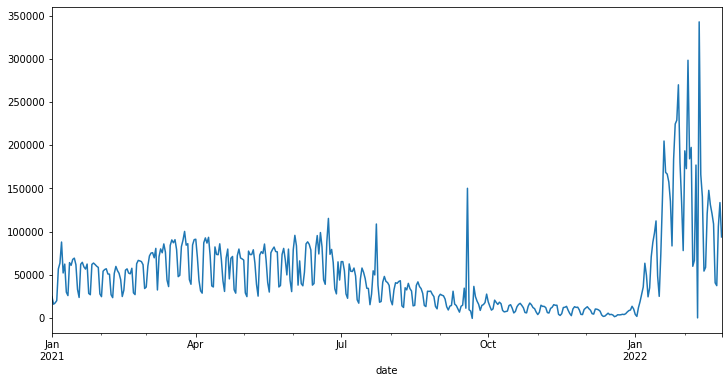

In [ ]:
# Plotando a variável Target
df_total['newCasesMS'].plot(figsize=(12,6))

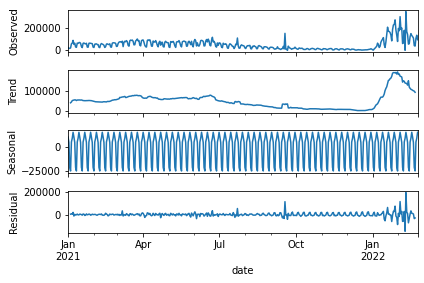

In [ ]:
# Verificando sazionalidade
results = seasonal_decompose(df_total['newCasesMS'])
results.plot();

## Definição dos Conjuntos de Treino e Teste
Divisão por períodos:
* Treino: 2021-03-07 a 2022-12-31
* Teste: 2022-01-01 a 2022-02-09

In [ ]:
df_train = df_total.loc['2021-03-07':'2021-12-31', df_total.columns]
df_train = df_train.sort_index() # Reordena o dataset através do index depois de ter feito a filtragem

df_test = df_total.loc['2022-01-01':'2022-02-09', df_total.columns]
df_test = df_test.sort_index()

In [ ]:
print('Dimensões do conjunto de treino: ', df_train.shape)
print('Dimensões do conjunto de teste: ', df_test.shape)

Dimensões do conjunto de treino:  (300, 31)
Dimensões do conjunto de teste:  (40, 31)


## Correlações

In [ ]:
round(df_train.corr(), 2)

,month,day,day_of_week,newDeaths,deaths,newCases,totalCases,newDeathsMS,deathsMS,newCasesMS,totalCasesMS,deaths_per_100k_inhabitants,totalCases_per_100k_inhabitants,deaths_by_totalCases,newRecovered,recovered,newSuspects,suspects,newTests,tests,tests_per_100k_inhabitants,newVaccinated,vaccinated,vaccinated_per_100_inhabitants,newVaccinated_second,vaccinated_second,vaccinated_second_per_100_inhabitants,vaccinated_single,vaccinated_single_per_100_inhabitants,vaccinated_third,vaccinated_third_per_100_inhabitants
month,1.00,-0.05,0.00,-0.84,0.93,-0.81,0.95,-0.82,0.93,-0.79,0.95,0.93,0.95,0.60,-0.37,0.97,-0.08,0.91,-0.07,0.97,0.97,-0.33,0.98,0.98,0.41,0.96,0.96,0.90,0.90,0.75,0.75
day,-0.05,1.00,-0.02,-0.01,0.03,-0.01,0.04,-0.01,0.03,-0.01,0.04,0.03,0.04,0.00,-0.06,0.04,-0.04,0.02,-0.03,0.05,0.05,0.01,0.04,0.04,0.02,0.06,0.06,0.04,0.04,0.10,0.10
day_of_week,0.00,-0.02,1.00,-0.07,0.00,-0.02,0.00,-0.03,0.01,0.03,0.00,0.00,0.00,0.01,-0.10,0.00,-0.01,0.00,-0.03,0.00,0.00,-0.29,0.00,0.00,-0.26,0.00,0.00,0.00,0.00,-0.00,-0.00
newDeaths,-0.84,-0.01,-0.07,1.00,-0.81,0.90,-0.83,0.99,-0.81,0.89,-0.83,-0.81,-0.83,-0.49,0.38,-0.84,0.07,-0.83,0.07,-0.82,-0.82,0.37,-0.85,-0.85,-0.33,-0.79,-0.79,-0.83,-0.83,-0.54,-0.54
deaths,0.93,0.03,0.00,-0.81,1.00,-0.76,1.00,-0.80,1.00,-0.73,1.00,1.00,1.00,0.80,-0.32,0.99,-0.09,0.98,-0.07,0.96,0.96,-0.10,0.95,0.95,0.48,0.82,0.82,0.88,0.88,0.52,0.52
newCases,-0.81,-0.01,-0.02,0.90,-0.76,1.00,-0.78,0.90,-0.76,0.99,-0.78,-0.76,-0.78,-0.43,0.37,-0.80,0.10,-0.75,0.05,-0.78,-0.78,0.44,-0.83,-0.83,-0.36,-0.79,-0.79,-0.81,-0.81,-0.57,-0.57
totalCases,0.95,0.04,0.00,-0.83,1.00,-0.78,1.00,-0.81,1.00,-0.75,1.00,1.00,1.00,0.75,-0.34,1.00,-0.09,0.99,-0.07,0.97,0.97,-0.13,0.97,0.97,0.48,0.85,0.85,0.91,0.91,0.55,0.55
newDeathsMS,-0.82,-0.01,-0.03,0.99,-0.80,0.90,-0.81,1.00,-0.80,0.90,-0.81,-0.80,-0.81,-0.48,0.37,-0.83,0.09,-0.81,0.08,-0.80,-0.80,0.36,-0.84,-0.84,-0.33,-0.77,-0.77,-0.81,-0.81,-0.53,-0.53
deathsMS,0.93,0.03,0.01,-0.81,1.00,-0.76,1.00,-0.80,1.00,-0.73,1.00,1.00,1.00,0.80,-0.32,0.99,-0.09,0.98,-0.07,0.96,0.96,-0.10,0.95,0.95,0.48,0.82,0.82,0.88,0.88,0.52,0.52
newCasesMS,-0.79,-0.01,0.03,0.89,-0.73,0.99,-0.75,0.90,-0.73,1.00,-0.75,-0.73,-0.75,-0.42,0.34,-0.78,0.11,-0.73,0.05,-0.76,-0.76,0.41,-0.80,-0.80,-0.37,-0.77,-0.77,-0.79,-0.79,-0.55,-0.55


# Preparação dos dados para o Modelo de Machine Learning

In [ ]:
# Guardando variável Target 
target = 'newCasesMS'

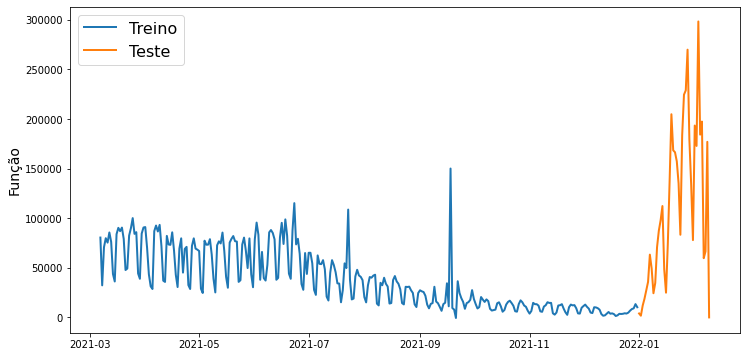

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,6))
ax.plot(df_train[target], label='Treino', linewidth=2)
ax.plot(df_test[target], label='Teste', linewidth=2)
ax.set_ylabel('Função', fontsize=14)
ax.legend(loc='best', fontsize=16)

In [ ]:
# Normalização dos dados
scaler = MinMaxScaler();

X_train_scaler = scaler.fit_transform(df_train[target].values.reshape(-1,1))
X_test_scaler = scaler.fit_transform(df_test[target].values.reshape(-1,1))


In [ ]:
print(X_test_scaler.shape,X_train_scaler.shape)

(40, 1) (300, 1)


In [ ]:
# Define generator
n_input = 10
n_features = 1
batch_size_train = 300 # Precisa ser divisível pelo número de amostras do X Trains e X Test, pôs define o número de amostras para fazer o gradiente
generator_train = TimeseriesGenerator(X_train_scaler, X_train_scaler, length=n_input, batch_size=batch_size_train)

In [ ]:
# Separando o X de treino e o Y de treino
X_train = []
y_train = []
for i in range(len(generator_train)):
  X, y = generator_train[i]
  X_train.append(X)
  y_train.append(y)


In [ ]:
# Define generator
batch_size_test = 40 # Precisa ser divisível pelo número de amostras do X Trains e X Test, pôs define o número de amostras para fazer o gradiente
generator_test = TimeseriesGenerator(X_test_scaler, X_test_scaler, length=n_input)

In [ ]:
# Separando o X de teste e o Y de teste
X_test = []
y_test = []
for i in range(len(generator_test)):
  X, y = generator_test[i]
  X_test.append(X)
  y_test.append(y)


In [ ]:
# Recebendo X e Y do Generator
batch_0 = generator_train[0]
X,y = batch_0

# 3º Implementação do LSTM

In [ ]:
# Define o modelo ‘identity’, ‘logistic’, ‘tanh’, ‘relu’
model = Sequential()
model.add(LSTM(200, activation='tanh', input_shape=(n_input,n_features)))
model.add(Dense(n_features, input_dim=n_input, activation='relu'))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 200)               161600    
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Treinando o model
model.fit(X_train, y_train, epochs=200, batch_size=30,  shuffle=False, validation_data=(X_test,y_test)) # shuffle False mantem a ordem dos dados na divisão

Epoch 1/200
10/10 [==============================] - 2s 47ms/step - loss: 0.0981 - val_loss: 0.0932
Epoch 2/200
10/10 [==============================] - 0s 6ms/step - loss: 0.0253 - val_loss: 0.0625
Epoch 3/200
10/10 [==============================] - 0s 5ms/step - loss: 0.0164 - val_loss: 0.0600
Epoch 4/200
10/10 [==============================] - 0s 5ms/step - loss: 0.0149 - val_loss: 0.0630
Epoch 5/200
10/10 [==============================] - 0s 5ms/step - loss: 0.0150 - val_loss: 0.0615
Epoch 6/200
10/10 [==============================] - 0s 6ms/step - loss: 0.0146 - val_loss: 0.0649
Epoch 7/200
10/10 [==============================] - 0s 5ms/step - loss: 0.0155 - val_loss: 0.0600
Epoch 8/200
10/10 [==============================] - 0s 6ms/step - loss: 0.0144 - val_loss: 0.0675
Epoch 9/200
10/10 [==============================] - 0s 6ms/step - loss: 0.0157 - val_loss: 0.0616
Epoch 10/200
10/10 [==============================] - 0s 7ms/step - loss: 0.0145 - val_loss: 0.0718
Epoch 11

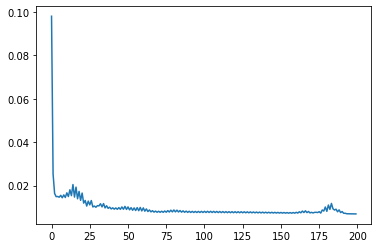

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

# 4ª Avaliação do modelo

In [ ]:
# Estimando a performace do modelo
score_treino = model.evaluate(X_train, y_train, verbose=0)
print(f'Score em Treino: {score_treino} MSE, ({sqrt(score_treino)} RMSE)')
score_teste = model.evaluate(X_test, y_test, verbose=0)
print(f'Score em Teste: {score_teste} MSE, ({sqrt(score_teste)} RMSE)')

Score em Treino: 0.006882733665406704 MSE, (0.08296224240825885 RMSE)
Score em Teste: 0.04675852507352829 MSE, (0.216237196322761 RMSE)


In [ ]:
# Gerando previsões para mostrar no gráfico
previsoes = model.predict(X_test, batch_size=40)
previsoes = scaler.inverse_transform(previsoes)

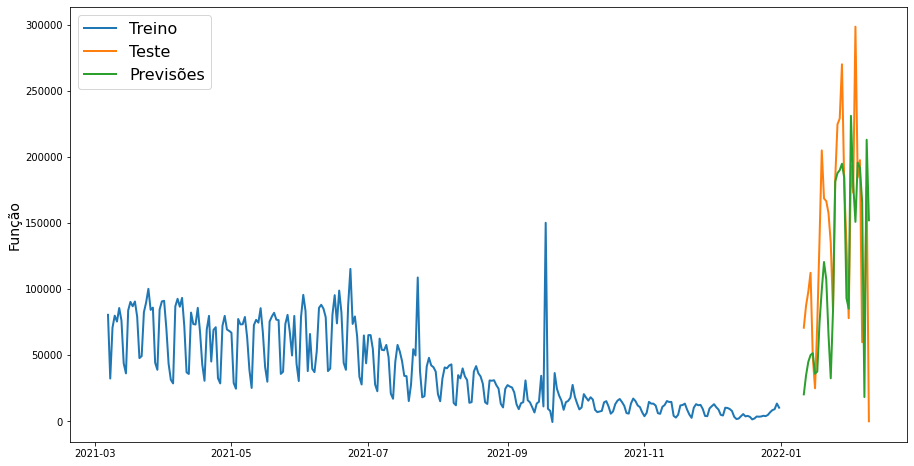

In [ ]:
# Gerando gráfico comparativo
previsto = df_test[n_input:].copy()
previsto['y'] = previsoes
fig, ax = plt.subplots(1, figsize=(15,8))
ax.plot(df_train[target], label='Treino', linewidth=2)
ax.plot(df_test[target][n_input:], label='Teste', linewidth=2)
ax.plot(previsto['y'] , label='Previsões', linewidth=2)
ax.set_ylabel('Função', fontsize=14)
ax.legend(loc='best', fontsize=16)

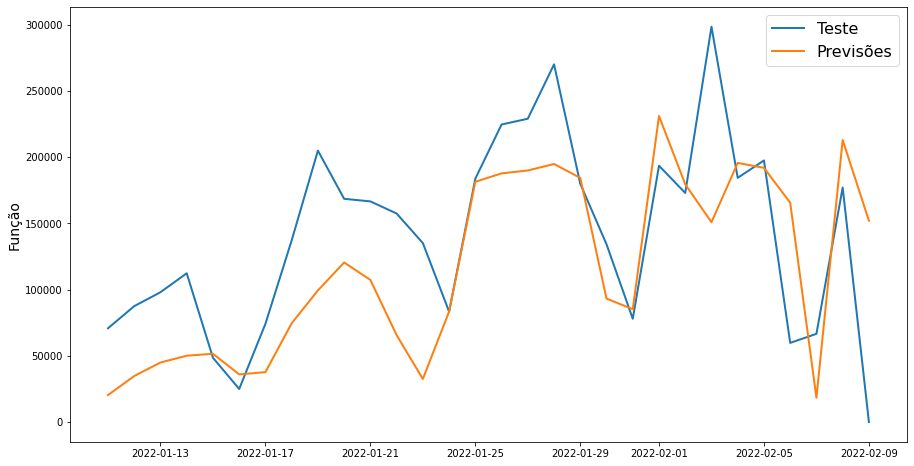

In [ ]:
# Gerando uma visão mais próxima das previsões
previsto = df_test[n_input:].copy()
previsto['y'] = previsoes
fig, ax = plt.subplots(1, figsize=(15,8))
ax.plot(df_test[target][n_input:], label='Teste', linewidth=2)
ax.plot(previsto['y'] , label='Previsões', linewidth=2)
ax.set_ylabel('Função', fontsize=14)
ax.legend(loc='best', fontsize=16)

### Realizando previsão do teste

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error as mape
mape_modelo = mape(df_test[target][n_input:],previsto['y'])
print(f'O valor do MAPE foi de: {mape_modelo}')

O valor do MAPE foi de: 2.2821716673597694e+19
